In [58]:
import pandas as pd
import json
import numpy as np
from tqdm import tqdm
from collections import *
import matplotlib.pylab as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, percentileofscore
import networkx as nx
from zipfile import ZipFile
import os


MAX_HEIGHT = 7536784

plt.rc('font', size=12) #controls default text size
plt.rc('axes', titlesize=12) #fontsize of the title
plt.rc('axes', labelsize=12) #fontsize of the x and y labels
plt.rc('xtick', labelsize=12) #fontsize of the x tick labels
plt.rc('ytick', labelsize=12) #fontsize of the y tick labels
plt.rc('legend', fontsize=12) #fontsize of the legend

In [25]:
# dictionary label for address tokens
DIC_TOKEN_ADDRESS_NAME = {'uusd':'UST','uluna':'LUNA', 'terra1kc87mu460fwkqte29rquh4hc20m54fxwtsx7gp': 'bLuna', 'terra1dzhzukyezv0etz22ud940z7adyv7xgcjkahuun': 'bETH', 'terra1hzh9vpxhsk8253se0vv5jj6etdvxu3nv8z07zu': 'aUST', 'terra14z56l0fp2lsf86zy3hty2z47ezkhnthtr9yq76': 'ANC', 'terra15gwkyepfc6xgca5t5zefzwy42uts8l2m4g40k6': 'MIR', 'terra1vxtwu4ehgzz77mnfwrntyrmgl64qjs75mpwqaz': 'mAAPL', 'terra1g4x2pzmkc9z3mseewxf758rllg08z3797xly0n': 'mABNB', 'terra1qelfthdanju7wavc5tq0k5r0rhsyzyyrsn09qy': 'mAMC (Delisted)', 'terra18ej5nsuu867fkx4tuy2aglpvqjrkcrjjslap3z': 'mAMD', 'terra165nd2qmrtszehcfrntlplzern7zl4ahtlhd5t2': 'mAMZN', 'terra1qqfx5jph0rsmkur2zgzyqnfucra45rtjae5vh6': 'mARKK', 'terra1w7zgkcyt7y4zpct9dw8mw362ywvdlydnum2awa': 'mBABA', 'terra1rhhvx8nzfrx5fufkuft06q5marfkucdqwq5sjw': 'mBTC', 'terra18wayjpyq28gd970qzgjfmsjj7dmgdk039duhph': 'mCOIN', 'terra149755r3y0rve30e209awkhn5cxgkn5c8ju9pm5': 'mDIS', 'terra19ya4jpvjvvtggepvmmj6ftmwly3p7way0tt08r': 'mDOT', 'terra1dk3g53js3034x4v5c3vavhj2738une880yu6kx': 'mETH', 'terra1mqsjugsugfprn3cvgxsrr8akkvdxv2pzc74us7': 'mFB', 'terra1l5lrxtwd98ylfy09fn866au6dp76gu8ywnudls': 'mGLXY', 'terra1m6j6j9gw728n82k78s0j9kq8l5p6ne0xcc820p': 'mGME (Delisted)', 'terra1h8arz2k547uvmpxctuwush3jzc8fun4s96qgwt': 'mGOOGL',
 'terra137drsu8gce5thf6jr5mxlfghw36rpljt3zj73v': 'mGS', 'terra18yqdfzfhnguerz9du5mnvxsh5kxlknqhcxzjfr': 'mHOOD', 'terra10h7ry7apm55h4ez502dqdv9gr53juu85nkd4aq': 'mIAU', 'terra15hp9pr8y4qsvqvxf3m4xeptlk7l8h60634gqec': 'mIAU (Delisted)', 'terra1ptdxmj3xmmljzx02nr4auwfuelmj0cnkh8egs2': 'mJNJ', 'terra1qsnj5gvq8rgs7yws8x5u02gwd5wvtu4tks0hjm': 'mKO', 'terra1227ppwxxj3jxz8cfgq00jgnxqcny7ryenvkwj6': 'mMSFT', 'terra1jsxngqasf2zynj5kyh0tgq9mj3zksa5gk35j4k': 'mNFLX', 'terra1dj2cj02zak0nvwy3uj9r9dhhxhdwxnw6psse6p': 'mNIO', 'terra17ana8hvzea0q7w367dm0dw48sxwql39qekpt7g': 'mNKE', 'terra1drsjzvzej4h4qlehcfwclxg4w5l3h5tuvd3jd8': 'mNVDA', 'terra1rh2907984nudl7vh56qjdtvv7947z4dujj92sx': 'mPYPL', 'terra1csk6tc7pdmpr782w527hwhez6gfv632tyf72cp': 'mQQQ', 'terra1246zy658dfgtausf0c4a6ly8sc2e285q4kxqga': 'mSBUX', 'terra1kscs6uhrqwy6rx5kuw5lwpuqvm3t6j2d6uf2lp': 'mSLV', 'terra1aa00lpfexyycedfg5k2p60l9djcmw0ue5l8fhc': 'mSPY', 'terra1u43zu5amjlsgty5j64445fr9yglhm53m576ugh': 'mSQ', 'terra14y5affaarufk3uscy2vr6pe6w6zqf2wpjzn5sh': 'mTSLA', 'terra1cc3enj9qgchlrj34cnzhwuclc4vl2z3jl7tkqg': 'mTWTR', 'terra1lvmx8fsagy70tv0fhmfzdw9h6s3sy4prz38ugf': 'mUSO', 'terra19cmt6vzvhnnnfsmccaaxzy2uaj06zjktu6yzjx': 'mVIXY', 'terra1zp3a6q6q4953cz376906g5qfmxnlg77hx3te45': 'mVIXY (Delisted)', 'terra1ez46kxtulsdv07538fh5ra5xj8l68mu8eg24vr': 'LOTA', 'terra17jnhankdfl8vyzj6vejt7ag8uz0cjc9crkl2h7': 'DPH', 'terra1kcthelkax4j9x8d3ny6sdag0qmxxynl3qtcrpy': 'MINE', 'terra1zsaswh926ey8qa5x4vj93kzzlfnef0pstuca0y': 'bPsiDP-24m', 'terra1s5eczhe0h0jutf46re52x5z4r03c8hupacxmdr': 'SPEC', 'terra1nef5jf6c7js9x6gkntlehgywvjlpytm7pcgkn4': 'LOOPC', 'terra1jx4lmmke2srcvpjeereetc9hgegp4g5j0p9r2q': 'LOOPRC', 'terra13xujxcrc9dqft4p9a8ls0w3j0xnzm6y2uvve8n': 'STT', 'terra19djkaepjjswucys4npd5ltaxgsntl7jf0xz7w6': 'TWD', 'terra1kvjscdgwuvwc6uzm4rqfjl6nlmuhj28tequlnc': 'XTRA', 'terra1vtr50tw0pgqpes34zqu60n554p9x4950wk8f63': 'MIAW', 'terra12897djskt9rge8dtmm86w654g7kzckkd698608': 'Psi', 'terra10f2mt82kjnkxqj2gepgwl637u2w4ue2z5nhz5j': 'nLuna', 'terra178v546c407pdnx5rer3hu8s2c0fc924k74ymnn': 'nETH', 'terra1u553zk43jd4rwzc53qrdrq4jc2p8rextyq09dj': 'cnLuna', 'terra1nagqpmyw55yjphea4rhntlfv87ugmeaj8ym756': 'cnETH', 'terra13k62n0285wj8ug0ngcgpf7dgnkzqeu279tz636': 'nAVAX', 'terra1jtdc6zpf95tvh9peuaxwp3v0yqszcnwl8j5ade': 'nATOM', 'terra1dy9kmlm4anr92e42mrkjwzyvfqwz66un00rwr5': 'VKRC', 'terra1mddcdx0ujx89f38gu7zspk2r2ffdl5enyz2u03': 'ORION', 'terra1r5506ckw5tfr3z52jwlek8vg9sn3yflrqrzfsc': 'TLAND', 'terra1php5m8a6qd68z02t3zpw4jv2pj4vgw4wz0t8mz': 'WHALE', 'terra1w0p5zre38ecdy3ez8efd5h9fvgum5s206xknrg': 'vUST', 'terra14tl83xcwqjy0ken9peu4pjjuu755lrry2uy25r': 'ETH', 'terra1aa7upykmmqqc63l924l5qfap8mrmx5rfdm0v55': 'WBTC', 'terra190tqwgqx7s8qrknz6kckct7v607cu068gfujpk': 'SOL', 'terra1dfasranqm4uyaz72r960umxy0w8t6zewqlnkuq': 'MATICet', 'terra1cetg5wruw2wsdjp7j46rj44xdel00z006e9yg8': 'BNB', 'terra1xvqlpjl2dxyel9qrp6qvtrg04xe3jh9cyxc6av': 'CAKE', 'terra12dfv3f0e6m22z6cnhfn3nxk2en3z3zeqy6ctym': 'LINK', 'terra1csvuzlf92nyemu6tv25h0l79etpe8hz3h5vn4a': 'SUSHI',
   'terra1wyxkuy5jq545fn7xfn3enpvs5zg9f9dghf6gxf': 'UNI', 'terra1ce06wkrdm4vl6t0hvc0g86rsy27pu8yadg3dva': 'USDTet', 'terra1pepwcav40nvj3kh60qqgrk8k07ydmc00xyat06': 'USDCet', 'terra1xfsdgcemqwxp4hhnyk4rle6wr22sseq7j07dnn': 'KUJI', 'terra188w26t95tf4dz77raftme8p75rggatxjxfeknw': 'sKUJI', 'terra133chr09wu8sakfte5v7vd8qzq9vghtkv4tn0ur': 'wstETH', 'terra1t9ul45l7m6jw6sxgvnp8e5hj8xzkjsg82g84ap': 'wstSOL', 'terra1c3xd5s2j3ejx2d94tvcjfkrdeu6rmz48ghzznj': 'wsbSOL', 'terra1jxypgnfa07j6w92wazzyskhreq2ey2a5crgt6z': 'LDO', 'terra1u5szg038ur9kzuular3cae8hq6q5rk5u27tuvz': 'webETH', 'terra1yg3j2s986nyp5z7r2lvt0hx3r0lnd7kwvwwtsc': 'stLuna', 'terra169edevav3pdrtjcx35j6pvzuv54aevewar4nlh': 'XDEFI', 'terra193c42lfwmlkasvcw22l9qqzc5q2dx208tkd7wl': 'BTL', 'terra17y9qkl8dfkeg4py7n0g5407emqnemc3yqk5rup': 'LunaX', 'terra1m3tdguf59xq3pa2twk5fjte5g6szj5y9x5npy7': 'LUNI', 'terra13awdgcx40tz5uygkgm79dytez3x87rpg4uhnvu': 'PLY', 'terra1u2k0nkenw0p25ljsr4ksh7rxm65y466vkdewwj': 'TFLOKI', 'terra1a8k3jyv3wf6k3zngza5h6srrxcckdf7zv90p6u': 'TFTIC', 'terra1xt9fgu7965kgvunnjts9zkprd8986kcc444q86': 'TFTICII', 'terra1vte2xv7dr8sfnrnwdf9arcyprqgr0hty5ads28': 'TFTICIII', 'terra1hmxxq0y8h79f3228vs0czc4uz5jdgjt0appp26': 'MOON', 'terra1xj49zyqrwpv5k928jwfpfy2ha668nwdgkwlrg3': 'ASTROC',
     'terra14lpnyzc9z4g3ugr4lhm8s4nle0tq8vcltkhzh7': 'xASTROC', 'terra1w8kvd6cqpsthupsk4l0clwnmek4l3zr7c84kwq': 'HALO', 'terra1kdfsdm3c4reun9j3m4mk3nmyw4a4ns7mj24q3j': 'PUG', 'terra1hnezwjqlhzawcrfysczcxs6xqxu2jawn729kkf': 'ORNE', 'terra1td743l5k5cmfy7tqq202g7vkmdvq35q48u2jfm': 'XRUNE', 'terra1366wmr8t8rrkh6mag8fagqxntmf2qe4kyte784': 'aLOT', 'terra1z09gnzufuflz6ckd9k0u456l9dnpgsynu0yyhe': 'SITY', 'terra13zx49nk8wjavedjzu8xkk95r3t0ta43c9ptul7': 'GLOW', 'terra100yeqvww74h4yaejj6h733thgcafdaukjtw397': 'APOLLO', 'terra1a7ye2splpfzyenu0yrdu8t83uzgusx2malkc7u': 'ABR', 'terra1y3d5qexmyac0fg53pfglh2pjk0664ymfvcq9mc': 'whGTPS', 'terra1dh9478k2qvqhqeajhn75a2a7dsnf74y5ukregw': 'PRISM', 'terra1l0y8yg0s86x299nqw0p6fhh7ngex3r4phtjeuq': 'SDOLLAR', 'terra1ku5e0dhutxhuxudsmsn5647wwcz6ndr3rsh90k': 'whSAIL', 'terra1rl0cpwgtwl4utnaynugevdje37fnmsea7rv4uu': 'whgSAIL', 'terra1042wzrwg2uk6jqxjm34ysqquyr9esdgm5qyswz': 'xPRISM', 'terra13fs83g5atgjwuh7c5ydzh6n7gecel6xyhhy2t5': 'CDE', 'terra1rl20t79ffsrqfa29rke48tj05gj9jxumm92vg8': 'CTX', 'terra13zaagrrrxj47qjwczsczujlvnnntde7fdt0mau': 'cLuna', 'terra1tlgelulz9pdkhls6uglfn5lmxarx7f2gxtdzh2': 'pLuna', 'terra17wkadg0tah554r35x6wvff0y5s7ve8npcjfuhz': 'yLuna', 'terra1cl7whtrqmz5ldr553q69qahck8xvk80fm33qjx': 'ATLO', 'terra1vchw83qt25j89zqwdpmdzj722sqxthnckqzxxp': 'LOCAL', 'terra15k5r9r8dl8r7xlr29pry8a9w7sghehcnv5mgp6': 'LUV', 'terra1f62tqesptvmhtzr8sudru00gsdtdz24srgm7wp': 'ROBO', 'terra1vwz7t30q76s7xx6qgtxdqnu6vpr3ak3vw62ygk': 'LUART', 'terra12hgwnpupflfpuual532wgrxu2gjp0tcagzgx4n': 'MARS', 'terra1a04v570f9cxp49mk06vjsm8axsswndpwwt67k4': 'XMARS', 'terra1vpws4hmpmpsqwnz3gljn8zj42rv7rkpc5atgt4': 'DFIAT', 'terra1hppnw4jppmrzzga4yvd8s87y3dwkhe27xwwl5d': 'CERES', 'terra1z3e2e4jpk4n0xzzwlkgcfvc95pc5ldq0xcny58': 'wasAVAX', 'terra1zd6let0zg0xjn2sestagxv4ax24a4ml6j40qdr': 'MINT', 'terra1ustvnmngueq0p4jd7gfnutgvdc6ujpsjhsjd02': 'SD', 'terra1ln2z938phz0nc2wepxpzfkwp6ezn9yrz9zv9ep': 'xSD', 'terra1uux6gwd6pzr0gfzrru5kne55cxex9d0700c72r': 'PAXG', 'terra1efjugpjc50d8sha7lr8s48cr7wmsthz94eevcl': 'whDAO', 'terra1su6g4t4vwx7y0uh3ksancyaurj4l6w9pfs40qt': 'LINK', 'terra14v9wrjs55qsn9lkvylsqela3w2ytwxzkycqzcr': 'SAYVE', 'terra1z55rhw0ut70jxdmpvge98mvj0rkwcz74q77z0u': 'GUIDES', 'terra1mt2ytlrxhvd5c4d4fshxxs3zcus3fkdmuv4mk2': 'BRO', 'terra1qryq5wreecx2wd3cdtzz94syr4z0a92l60asds': 'bBRO', 'terra15zvyhmv6gwddht7kt4q6w5nasn4tcpgzcdfmgr': 'GTPS', 'terra15pkdjxv2ewjzn9x665y26pfz2h6ymak4d4e8se': 'GFI', 'terra1fyjsxx73jrufw8ufgtuswa773dvdkny92k70wa': 'ULC', 'terra1689ys6p6gfu0q6xrjqkzfn80sdyhurjqn0jfdl': 'SST', 'terra1rg8f993m9834afwazersesgx7jjxv4p87q9wvc': 'ATLAS', 'terra1nc6flp57m5hsr6y5y8aexzszy43ksr0drdr8rp': 'AUDIO', 'terra1hj8de24c3yqvcsv9r8chr03fzwsak3hgd8gv3m': 'AVAX', 'terra1apxgj5agkkfdm2tprwvykug0qtahxvfmugnhx2': 'BAT', 'terra1skjr69exm6v8zellgjpaa2emhwutrk5a6dz7dd': 'BUSDbs', 'terra1zmclyfepfmqvfqflu8r3lv6f75trmg05z7xq95': 'DAI', 'terra1dtqlfecglk47yplfrtwjzyagkgcqqngd5lgjp8': 'MATICpo', 'terra15a9dr3a2a2lj5fclrw35xxg9yuxg0d908wpf2y': 'MIMet', 'terra1ht5sepn28z999jx33sdduuxm9acthad507jg9q': 'RAY', 'terra17h82zsq6q8x5tsgm5ugcx4gytw3axguvzt4pkc': 'SBR', 'terra1huku2lecfjhq9d00k5a8dh73gw7dwe6vvuf2dd': 'SHIB', 'terra1dkam9wd5yvaswv4yq3n2aqd4wm5j8n82qc0c7c': 'SRMso', 'terra1pvel56a2hs93yd429pzv9zp5aptcjg5ulhkz7w': 'USDCav', 'terra1yljlrxvkar0c6ujpvf8g57m5rpcwl7r032zyvu': 'USDCbs', 'terra1kkyyh7vganlpkj0gkc2rfmhy858ma4rtwywe3x': 'USDCpo', 'terra1e6mq63y64zcxz8xyu5van4tgkhemj3r86yvgu4': 'USDCso', 'terra1eqvq3thjhye7anv6f6mhxpjhyvww8zjvqcdgjx': 'USDTav', 'terra1vlqeghv5mt5udh96kt5zxlh2wkh8q4kewkr0dd': 'USDTbs', 'terra1hd9n65snaluvf7en0p4hqzse9eqecejz2k8rl5': 'USDTso', 'terra1fpfn2kkr8mv390wx4dtpfk3vkjx9ch3thvykl3': 'gOHM', 'terra1qvlpf2v0zmru3gtex40sqq02wxp39x3cjh359y': 'mSOL', 'terra1w7ywr6waxtjuvn5svk5wqydqpjj0q9ps7qct4d': 'stETH', 'terra1srp2u95kxps35nvan88gn96nfqhukqya2d0ffc': 'LCT', 'terra18zqcnl83z98tf6lly37gghm7238k7lh79u4z9a': 'bATOM', 'terra128pe5jpempxu0nws5lw28se9zknhsr78626cpn': 'webATOM', 'terra1laczhlpxlgmrwr9un9ds74qxd2fj4754nf82dn': 'WCOIN', 'terra1thhm2u93m2stytzynhsxh5h3jrtg540x4punqy': 'LCTfancard', 'terra1yeyr6taynkwdl85ppaggr3zr8txhf66cny2ang': 'KNTC', 'terra1g53pyke8jtmt4lwvk4yl0xaqc4u0qlsl8dz3ex': 'kUST', 'terra1rl4zyexjphwgx6v3ytyljkkc4mrje2pyznaclv': 'STEAK', 'terra1jkkt5638cd5pur0u5jnr2juw0v6hz5d6z8xu8m': 'CST', 'terra1kz7qszu7p4dg9lts7m9m7lpuarsnan47jh3fam': 'CSTfancard', 'terra1amz5c45l34n7w8m5a3z7rd7u0k037x4nnsemwj': 'NWLD', 'terra1cdc6nlsx0l6jmt3nnx7gxjggf902wge3n2z76k': 'FURY', 'terra17n223dxpkypc5c48la7aqjvverczg82ga3cr93': 'RCT', 'terra14vw4sfqwe7jw8ppcc7u44vq7hy9qa2nlstnxmu': 'VITC', 'terra1948uvsah8aw40dhsa9mhl3htq8lraj0smlh77g': 'SB', 'terra1rz964297kvt86rteajhtp4hsffhcum0ye8eljh': 'TOAD', 'terra1yhlhrea3rgyx2xdnsswsfakn28qa8z7yp5gmhd': 'orionASTRO', 'terra1j4hwavavmtsafa6zr0npalfz3tk9gf3p4787mp': 'RETRO', 'terra16wggm67a34msdxasg2vergm2pt289y7930wv7d': 'TND', 'terra1n9k2he20h5vpyn4mgv7pg4pzvw2n3wc4a86v3g': 'sTND', 'terra1ezz5xply2v3xdyv32gy5tcd7zq4k235q4xtzwe': 'NWT', 'terra1mpq5zkkm39nmjrjg9raknpfrfmcfwv0nh0whvn': 'NEB', 'terra1c00vskhyzdv0z63z2tyetzx2qma67n2z3vzyn0': 'bSOL', 'terra16gqgpuy7z64chzz3su2xugjgrhuj3h89wx2z59': 'BST', 'terra1l670q2m9j3npltmsqe428mwu0msw336m8jtq00': 'KRX', 'terra1fy7lnlls8ufzfeefc98tkn66x07scud2s3d23p': 'BSTfancard', 'terra1f5m40hs40sa9nuku776swjljsa2t39h58uhlw3': 'KRXfancard', 'terra1zjhsuvuy5z7ucvx56facefmlrrgluhun27chlf': 'ILT', 'terra14s8p2wnvh5vpxn4fgu562m2sm9780pk5gvkf9a': 'ILTfancard', 'terra1kn85pdmrhhk2upjj8hf97lx3w3jg6gyzasyksp': 'LIRA', 'terra1rjf3c4ayvx2d6pej6fanjhe54a2ds8dlh9f69s': 'PEPON', 'terra102cjx95xvww7cl9l6usxltk75ww3mpxtyw4lpm': 'TUNA', 
     'terra13eekqp0zgj55arjuacpxqxzgqy2uydf5wzzqns9ddgpepj377afqflunf3': 'cLUNA', 'terra1hjyl8ymsd9sn59kx733aka4rxfelf43pw6fjjf': 'IDC', 'terra1wvk6r3pmj0835udwns4r5e0twsclvcyuq9ucgm': 'ampLUNC',
    'ukrw':'KRT','cw20:terra1dh9478k2qvqhqeajhn75a2a7dsnf74y5ukregw':'PRISM Token'
    }

# Read data

## Read arbs data

In [26]:
arbs = []
path_data = './data'
fns = 'arbs.part1.json arbs.part2.json'.split()
for fn in fns:
    with ZipFile(os.path.join(path_data, fn+'.zip')) as myzip:
        with myzip.open(fn) as myfile:
            arbs += json.load(myfile)
print(f"Read #arbs {len(arbs)}")

Read #arbs 188564


## Read path length

In [27]:
# read path lens
fin = open('./data/path_arbs_len_distribution.json')
path_len = json.load(fin)
fin.close()

## Read blocks data and summarize data

In [28]:
# summarize per block data
def create_df_per_block(arbs):
    # read some blocks info
    print('reading block_info.csv')
    df = pd.read_csv('./data/block_info.csv.zip')
    df = df[df.height<=MAX_HEIGHT]

    dic_info_blocks__n_txs = dict(df['height number_of_txs'.split()].values)
    dic_info_blocks__n_txs_exec = dict(df['height number_of_txs_with_execute_contract_msg'.split()].values)
    dic_blocks = defaultdict(lambda : dict([('n_arbs_successful',0),('other_arbs_failed',set())]))
    for arb in tqdm(arbs):
        dic_blocks[arb['block']]['n_arbs_successful']+=1
        dic_blocks[arb['block']]['other_arbs_failed'].update(set([e['txhas'] for e in arb['other_arbs'] if e['success']==False]))
    for k,v in dic_blocks.items():
        dic_blocks[k]['n_arbs_failed'] = len(v['other_arbs_failed'])
        dic_blocks[k]['n_txs'] = dic_info_blocks__n_txs[k]
        dic_blocks[k]['n_txs_exec'] = dic_info_blocks__n_txs_exec[k]
        dic_blocks[k]['height'] = k

    df_blocks = pd.DataFrame(dic_blocks.values())
    df_blocks['n_arbs'] = df_blocks['n_arbs_successful']+df_blocks['n_arbs_failed']
    return df_blocks

df_blocks = create_df_per_block(arbs)
df_blocks.head()

reading block_info.csv


100%|██████████| 188564/188564 [00:01<00:00, 161420.96it/s]


,n_arbs_successful,other_arbs_failed,n_arbs_failed,n_txs,n_txs_exec,height,n_arbs
0,1,{601c31ef32a470c7f8258cb2d32797853c43a26df3346...,1,26,18,7295407,2
1,1,{},0,34,24,7295368,1
2,1,{1eb13394bfc6758b512f2bf6b1664cf3a2727d2fa90f5...,1,29,23,7295303,2
3,1,{},0,26,23,7295408,1
4,1,{f57b31fadc1341051f5b47085480304160197b89c8be0...,1,27,21,7295418,2


## Create dataframe for Arbitrages

In [29]:
def create_df_arbs(arbs):
    res = []
    for arb in tqdm(arbs):
        r = {}
        r['txhash'] = arb['arb']['txhash']
        r['profit'] = arb['arb']['profit']
        r['profit_rate'] = arb['arb']['profit_rate']
        r['amount_in'] = arb['arb']['amount_in']
        r['amount_out'] = arb['arb']['amount_out']
        r['token_in'] = arb['arb']['token_in']
        r['contract'] = arb['arb']['contract']
        r['sender'] = arb['arb']['sender']
        r['height'] = arb['block']
        res.append(r)

    df_arbs = pd.DataFrame(res)
    df_arbs['token_in_label'] = df_arbs.token_in.apply(lambda x: DIC_TOKEN_ADDRESS_NAME[x])
    return df_arbs

df_arbs = create_df_arbs(arbs)
df_arbs.head()

100%|██████████| 188564/188564 [00:00<00:00, 682880.76it/s]


,txhash,profit,profit_rate,amount_in,amount_out,token_in,contract,sender,height,token_in_label
0,f8e35eedf50239329c3afeb541cbcab1a550f08188e9b8...,2446059,0.012230,200000000,202446059,uusd,terra1a8pae49synr07t0q058pu39gclrqz0eq04dngt,terra1qdj0ku3sww7pcy36kf7q6rupga9rcur8v5plp5,7295407,UST
1,0935909ed8f6d6af7f5920fd69c80f6f939198ff55b632...,4420758,0.002852,1550000000,1554420758,cw20:terra1dh9478k2qvqhqeajhn75a2a7dsnf74y5ukregw,terra1eqmxmc4j39cyv5zk52dyjmhmhztudj24n77n2q,terra1vadgym4eqxsxetl9xgka8cfkd5mjcvwc2f8pyt,7295368,PRISM Token
2,c04fec46e1e39a1607fe36e88000a40ef0ca2bd937b625...,1058119,0.000971,1089914601,1090972720,uusd,terra1egqmcaupc87sdg6sqmzypuv06ykxkek3j7s4w5,terra1nyud8zzctrks6ltnhhn4q820umnvqg39hc6ydz,7295303,UST
3,81e7b25a49e859df22ffde299d1c463cbf4e00d74b6e82...,17813171249,0.343112,51916450088,69729621337,terra169edevav3pdrtjcx35j6pvzuv54aevewar4nlh,terra1g7jjjkt5uvkjeyhp8ecdz4e4hvtn83sud3tmh2,terra1p0242gewpx8pcr8hnp57ylmzef6mkp664ysxw4,7295408,XDEFI
4,d40e6d1969c5f0a50287eacd24494774770adecbd06e9e...,11558103,0.003986,2900000000,2911558103,cw20:terra1dh9478k2qvqhqeajhn75a2a7dsnf74y5ukregw,terra1eqmxmc4j39cyv5zk52dyjmhmhztudj24n77n2q,terra1tekdk5q9w22cf8xzsr43xdgre6zfgz94d5zguh,7295418,PRISM Token


# Data description

## Rate of blocks with successfull arbs

In [30]:
heights = [a['block'] for a in arbs]
print('Block total', max(heights)-min(heights))
print('Different blocks with arbs', len(set(heights)), 100*(len(set(heights))/ (max(heights)-min(heights))),'%')

Block total 2801943
Different blocks with arbs 125766 4.488528139223389 %


## Distribution of txs with execute contract msg per block

count    125766.000000
mean         28.101371
std          22.030930
min           1.000000
25%          16.000000
50%          23.000000
75%          33.000000
max         892.000000
Name: n_txs_exec, dtype: float64


Text(0, 0.5, 'Number of blocks')

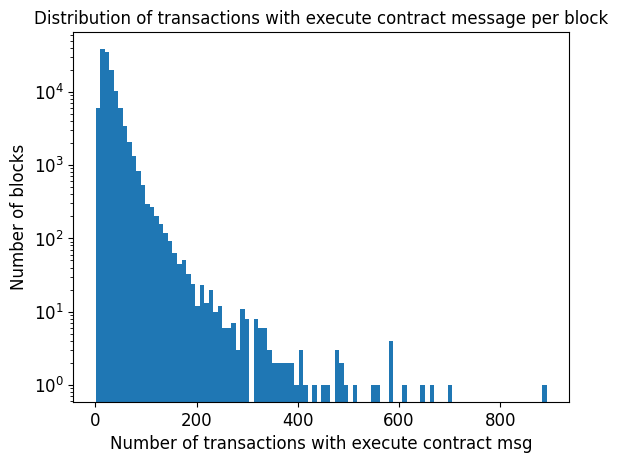

In [83]:
df_blocks.n_txs_exec.hist(bins=100)
plt.title('Distribution of transactions with execute contract message per block')
plt.yscale('log')
plt.grid()
print(df_blocks.n_txs_exec.describe())
plt.xlabel('Number of transactions with execute contract msg')
plt.ylabel('Number of blocks')

## Distribution of: execute msg, arbs, successful arb and failed arbs per block

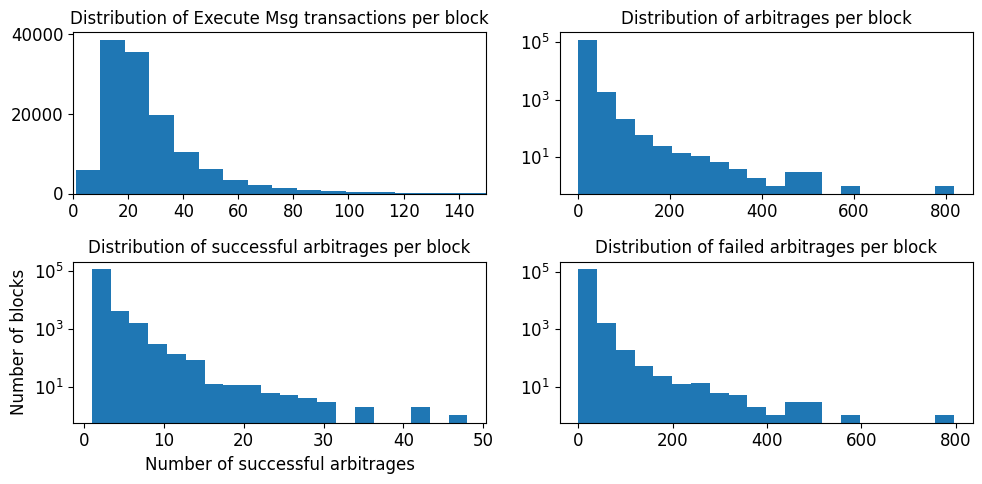

In [71]:
plt.subplot(2,2,1)
df_blocks.n_txs_exec.hist(bins=100)
plt.title('Distribution of Execute Msg transactions per block')
plt.grid()
plt.xlim(0,150)

plt.subplot(2,2,2)
df_blocks.n_arbs.hist(bins=20)
plt.title('Distribution of arbitrages per block')
plt.grid()
plt.yscale('log')

plt.subplot(2,2,3)
df_blocks.n_arbs_successful.hist(bins=20)
plt.title('Distribution of successful arbitrages per block')
plt.xlabel('Number of successful arbitrages')
plt.ylabel('Number of blocks')
plt.grid()
plt.yscale('log')

plt.subplot(2,2,4)
df_blocks.n_arbs_failed.hist(bins=20)
plt.title('Distribution of failed arbitrages per block')
plt.grid()
plt.yscale('log')


fig = plt.gcf()
fig.set_size_inches(10,5)
fig.tight_layout()

## Senders top 10

In [34]:
df_senders_top10 = pd.DataFrame(
    [
        {
            "Sender": sender,
            "Number of succesful arbs": n,
            "Number of contracts": df_arbs[(df_arbs.sender == sender)].contract.nunique(),
            "Percentage": 100 * n / len(df_arbs),
        }
        for sender, n in Counter(df_arbs.sender).most_common(10)
    ]
)

display(df_senders_top10)

print("Percentage of arbitrage of the top 10 senders", df_senders_top10.Percentage.sum())


,Sender,Number of succesful arbs,Number of contracts,Percentage
0,terra1fgef888tuj3g8tmpxp4klvthq4eqk8a2yw7vsw,27197,6,14.423220
1,terra1lywrs72lpsptu68usehlae5yq94wsuk2g6fa3m,10232,13,5.426274
2,terra1n3s52w97j599sq3k4wcr3j0027j0stnfttnjvg,7385,7,3.916442
3,terra1nyud8zzctrks6ltnhhn4q820umnvqg39hc6ydz,7193,2,3.814620
4,terra16kd4ucrkj3mu2xpt25075s3jsztkx9ltf3tj9y,4921,1,2.609724
5,terra1xjpy3hu7qzun8p3h3cuf4w2v4f98w376mjj74l,4797,13,2.543964
6,terra140d3kgus5nxnqextv6fahzncfvp90r7t0s6mjp,3684,5,1.953713
7,terra1lxyhvhhdjc3sxk0kjeljtqnxjf7ek6asxxyp7q,3645,3,1.933031
8,terra1cxspyydlp4qdu0pzetg9au549n29tnvs4t3kej,3334,2,1.768100
9,terra1qfg2exflsshg23gs5w4ml37hwnunzthtx2gpp6,3288,2,1.743705


Percentage of arbitrage of the top 10 senders 40.1327931100316


## Contracts top 10

In [35]:
df_contracts_top10 = pd.DataFrame(
    [
        {
            "Contract": contract,
            "Number of succesful arbs": n,
            "Number of senders": df_arbs[(df_arbs.contract == contract)].sender.nunique(),
            "Percentage": 100 * n / len(df_arbs),
        }
        for contract, n in Counter(df_arbs.contract).most_common(10)
    ]
)

display(df_contracts_top10)

print("Percentage of arbitrage of the top 10 contracts", df_contracts_top10.Percentage.sum())


,Contract,Number of succesful arbs,Number of senders,Percentage
0,terra1p9zmnwqrfpzx0k585r3lhrqhlakmrnar2cljt9,17130,1,9.084449
1,terra1kz93zt3ng7kags09qy06a079wjl3qpzfp0axsn,14195,8,7.527948
2,terra1nuzl3sppu0suws9zml5psu8tmuqk5dnr88n8kc,10664,8,5.655374
3,terra10j88evvssl4m0ztj2hcelf993j5a0xd3ezd7se,10314,80,5.469761
4,terra1myl5pk2a7qj37yu6dgmy68rxkznmq9nrk69nrj,8367,50,4.437220
5,terra1wswy9763nhugvphchcdc438r3ejvskjjz5h0rs,7731,8,4.099934
6,terra139y02s9urkkyesukndrqdjmqj7gkk5dltd05v8,7060,8,3.744087
7,terra19rltg2vaurffa25cvtm5zey9muhaxflfxt5e2p,6152,1,3.262553
8,terra1egqmcaupc87sdg6sqmzypuv06ykxkek3j7s4w5,5927,1,3.143230
9,terra1sg877xutwmyvsz45jrlwcdhx07jac33433499e,5634,3,2.987845


Percentage of arbitrage of the top 10 contracts 49.412401094588574


# Searchers

## Identify searchers

In [36]:
def create_edges_csv_for_gephi_plot(df_arbs):
    # create a csv with edges for the gephi plot
    df_graph = df_arbs["contract sender".split()].drop_duplicates()
    df_graph.columns = "Source Target".split()
    df_graph.to_csv("edges.csv", index=False)


def compute_connected_componentes_to_identify_searchers_and_add_to_df_arbs(df_arbs):
    # compute connected components
    G = nx.Graph()
    for edge in df_arbs["contract sender".split()].values.tolist():
        G.add_edge(edge[0], edge[1])
    conected_components = list(nx.connected_components(G))

    # add component id as a column in df_arbs
    df_arbs["searcher"] = [[s in cc for cc in conected_components].index(True) for s in df_arbs.sender]

    # add componenet to match graph
    address_colors = {
        "terra10y236ka2k4a4mtrtxht2d6rvpsqen5fge67dlx": "#df89ff",  #'violeta'
        "terra1nqmgv2whlnqg7kt09g3hanuy66lyf2nh549g6x": "#00c4ff",  # celeste',
        "terra17qe3ajzwtend6lpywhyh70yfhap8vrkwnvnh0q": "#ff5584",  # rosa',
        "terra15vjdaqxsv473pyxxaxg9dwr8k78f2speas7z89": "#73c000",  # verde
        "terra1wrlw9v4avh0cr663zftgc24uqjfle8wlqj8jse": "#02bc94",  # verde_marino
        "terra1et8zps4v9u9xyua0ftxrf9y7zc75rnyr2tdwum": "#4c463e",  # negro
        "terra1c3v8kdgwf24hx07jwescl97lu89v2qw6extzn6": "#ff8807",  # naranja
    }

    # add searcher_color to df_arbs
    address_colors_componente_id_nx = defaultdict(lambda: "#edeff2")
    for k in address_colors:
        address_colors_componente_id_nx[
            df_arbs[(df_arbs.contract == k) | (df_arbs.sender == k)].searcher.unique()[0]
        ] = address_colors[k]
    address_colors_componente_id_nx
    df_arbs["searcher_color"] = df_arbs.searcher.apply(lambda x: address_colors_componente_id_nx[x])


compute_connected_componentes_to_identify_searchers_and_add_to_df_arbs(df_arbs)
df_arbs.head()


,txhash,profit,profit_rate,amount_in,amount_out,token_in,contract,sender,height,token_in_label,searcher,searcher_color
0,f8e35eedf50239329c3afeb541cbcab1a550f08188e9b8...,2446059,0.012230,200000000,202446059,uusd,terra1a8pae49synr07t0q058pu39gclrqz0eq04dngt,terra1qdj0ku3sww7pcy36kf7q6rupga9rcur8v5plp5,7295407,UST,0,#73c000
1,0935909ed8f6d6af7f5920fd69c80f6f939198ff55b632...,4420758,0.002852,1550000000,1554420758,cw20:terra1dh9478k2qvqhqeajhn75a2a7dsnf74y5ukregw,terra1eqmxmc4j39cyv5zk52dyjmhmhztudj24n77n2q,terra1vadgym4eqxsxetl9xgka8cfkd5mjcvwc2f8pyt,7295368,PRISM Token,0,#73c000
2,c04fec46e1e39a1607fe36e88000a40ef0ca2bd937b625...,1058119,0.000971,1089914601,1090972720,uusd,terra1egqmcaupc87sdg6sqmzypuv06ykxkek3j7s4w5,terra1nyud8zzctrks6ltnhhn4q820umnvqg39hc6ydz,7295303,UST,1,#edeff2
3,81e7b25a49e859df22ffde299d1c463cbf4e00d74b6e82...,17813171249,0.343112,51916450088,69729621337,terra169edevav3pdrtjcx35j6pvzuv54aevewar4nlh,terra1g7jjjkt5uvkjeyhp8ecdz4e4hvtn83sud3tmh2,terra1p0242gewpx8pcr8hnp57ylmzef6mkp664ysxw4,7295408,XDEFI,2,#edeff2
4,d40e6d1969c5f0a50287eacd24494774770adecbd06e9e...,11558103,0.003986,2900000000,2911558103,cw20:terra1dh9478k2qvqhqeajhn75a2a7dsnf74y5ukregw,terra1eqmxmc4j39cyv5zk52dyjmhmhztudj24n77n2q,terra1tekdk5q9w22cf8xzsr43xdgre6zfgz94d5zguh,7295418,PRISM Token,0,#73c000


## Distribution of number of contracts and sender address for searchers

Rate of searchers that use only one sender address 0.5714285714285714


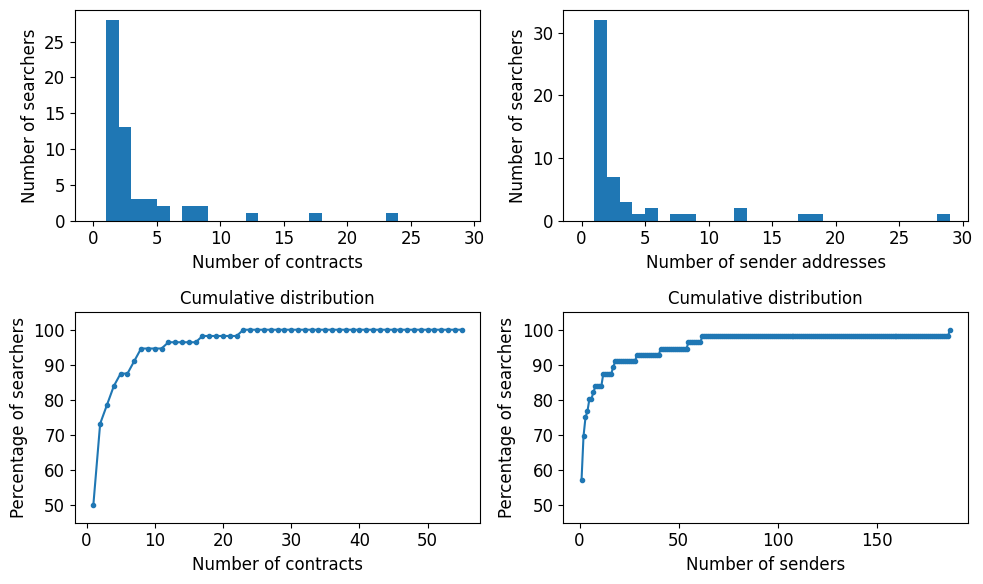

In [37]:
print('Rate of searchers that use only one sender address', (df_arbs.groupby('searcher').nunique().sender==1).mean())

plt.subplot(2,2,1)
df_arbs.groupby('searcher').nunique().contract.hist(bins=range(30))
plt.xlabel('Number of contracts')
plt.ylabel('Number of searchers')
plt.grid()

plt.subplot(2,2,2)
df_arbs.groupby('searcher').nunique().sender.hist(bins=range(30))
plt.xlabel('Number of sender addresses')
plt.ylabel('Number of searchers')
plt.grid()


dom = range(1,56)
plt.subplot(2,2,3)
s = df_arbs.groupby('searcher').nunique().contract
plt.plot(dom, [100*(s<=i).mean() for i in dom],'.-')
plt.xlabel('Number of contracts')
plt.ylabel('Percentage of searchers')
plt.title("Cumulative distribution")
plt.ylim(45,105)

dom = range(1,188)
plt.subplot(2,2,4)
s = df_arbs.groupby('searcher').nunique().sender
plt.plot(dom, [100*(s<=i).mean() for i in dom],'.-')
plt.xlabel('Number of senders')
plt.ylabel('Percentage of searchers')
plt.title("Cumulative distribution")
plt.ylim(45,105)

fig = plt.gcf()
fig.set_size_inches(10,6)
fig.tight_layout()

## Relations between number of contracts and number of senders address for searchers

Text(0.5, 1.0, 'Searchers relation between number of contracts and senders\n(pearson rho:0.3487, pval:0.0084)')

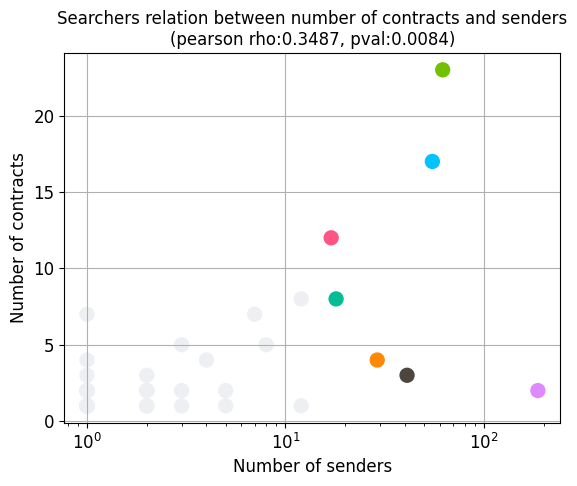

In [38]:
d = df_arbs.groupby("searcher searcher_color".split(), as_index=False).nunique()[
    "sender contract searcher searcher_color".split()
]
plt.scatter(d.sender, d.contract, c=d.searcher_color, s=100)
plt.xscale("log")
rho, pval = pearsonr(d.sender, d.contract)
plt.xlabel("Number of senders")
plt.ylabel("Number of contracts")
plt.grid()
plt.title(
    f"Searchers relation between number of contracts and senders\n(pearson rho:{rho:.4f}, pval:{pval:.4f})"
)


## Searcher arbs distribution

Rate and number of searchers with more than 10 successful arbs 0.7857142857142857 44
Rate and number of searchers with more than 100 successful arbs 0.5892857142857143 33
Rate and number of searchers with more than 1000 successful arbs 0.35714285714285715 20


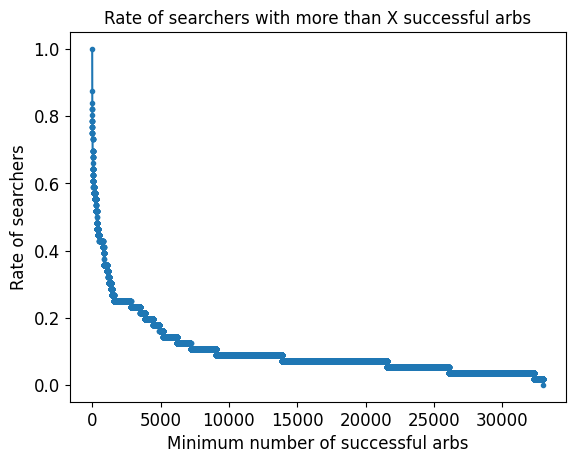

In [39]:
v_arbs_per_searcher = df_arbs.groupby('searcher').count().txhash.values
_ = plt.plot([ (v_arbs_per_searcher>i).mean() for i in range(0, v_arbs_per_searcher.max()+1, 1)], '.-')
plt.xlabel('Minimum number of successful arbs')
plt.ylabel('Rate of searchers')
plt.title('Rate of searchers with more than X successful arbs')

print('Rate and number of searchers with more than 10 successful arbs', (v_arbs_per_searcher>10).mean(), (v_arbs_per_searcher>10).sum())
print('Rate and number of searchers with more than 100 successful arbs', (v_arbs_per_searcher>100).mean(), (v_arbs_per_searcher>100).sum())
print('Rate and number of searchers with more than 1000 successful arbs', (v_arbs_per_searcher>1000).mean(), (v_arbs_per_searcher>1000).sum())

# Token in

Text(0.5, 0, 'Number of arbitrages that start with token in')

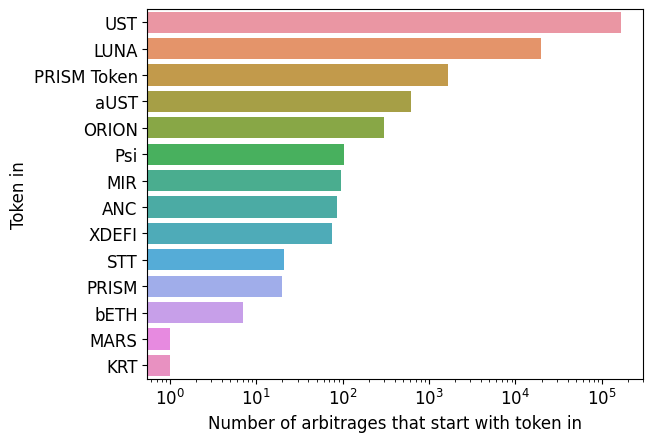

In [72]:
sns.countplot(y=df_arbs.token_in_label, order = df_arbs.token_in_label.value_counts().index)
plt.xscale('log')
plt.ylabel('Token in')
plt.xlabel("Number of arbitrages that start with token in")

/var/folders/jd/8zq1tlsj3clgxx9lzf934cq40000gn/T/ipykernel_71148/2057574243.py:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (t, v) in enumerate(df_arbs.groupby('token_in_label').count().sender.sort_values(ascending=False).head(10).iteritems()):


(0.5483002152384003, 3024219.130169451)

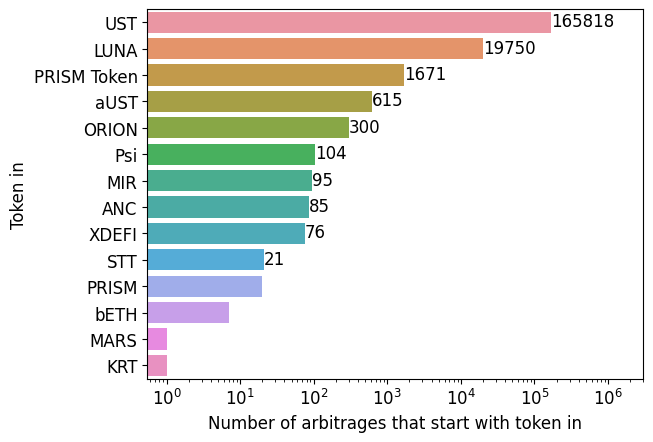

In [73]:
sns.countplot(y=df_arbs.token_in_label, order = df_arbs.token_in_label.value_counts().index)
plt.xscale('log')
plt.ylabel('Token in')
plt.xlabel("Number of arbitrages that start with token in")

for i, (t, v) in enumerate(df_arbs.groupby('token_in_label').count().sender.sort_values(ascending=False).head(10).iteritems()):
    plt.text(v,i+0.15,str(v))
new_xlim = (plt.xlim()[0],plt.xlim()[1]*10)
plt.xlim(new_xlim)

# Profit

## Profit summary

In [42]:
print('Porfit only arbs starting with UST', df_arbs[df_arbs.token_in == 'uusd'].profit.sum()/10**6)
print('Porfit only arbs starting with LUNA', df_arbs[df_arbs.token_in == 'uluna'].profit.sum()/10**6)
print('Rate of arbs with profit rate <=1', (df_arbs[(df_arbs.token_in=='uusd') | (df_arbs.token_in == 'uluna')].profit_rate<=1).mean())

Porfit only arbs starting with UST 16243704.51671
Porfit only arbs starting with LUNA 20569.770751
Rate of arbs with profit rate <=1 0.9964810743231591


## Distribution of profit rate (for arbs with profit rate <=1)

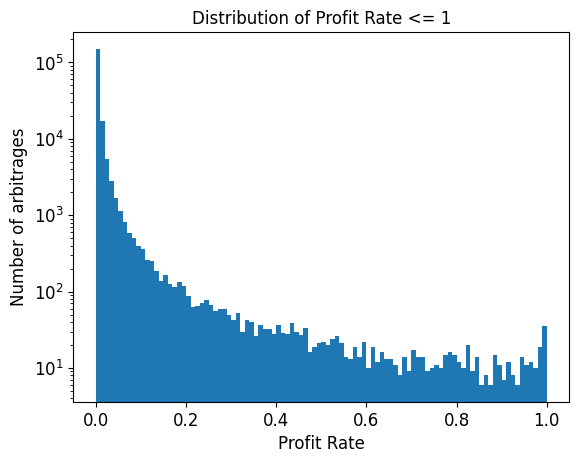

In [81]:
profit_rate = df_arbs[
    ((df_arbs.token_in == "uusd") | (df_arbs.token_in == "uluna")) & (df_arbs.profit_rate <= 1)
].profit_rate
profit_rate.hist(bins=100)
plt.yscale("log")
plt.ylabel("Number of arbitrages")
plt.xlabel("Profit Rate")
plt.grid()
_ = plt.title("Distribution of Profit Rate <= 1")


In [45]:
print('UST')
mask = (df_arbs.token_in=='uusd')  
print('Correlation between amount of arbs and profit sum by searcher',
       pearsonr(df_arbs[mask].groupby('searcher').count().profit, df_arbs[mask].groupby('searcher').sum(numeric_only=True).profit)
    )
print('Correlation between number of senders address and profit sum by searcher',
      pearsonr(df_arbs[mask].groupby('searcher').sender.nunique(),  df_arbs[mask].groupby('searcher').sum(numeric_only=True).profit)
    )
print('Correlation between number of scontracts and profit sum by searcher',
      pearsonr(df_arbs[mask].groupby('searcher').contract.nunique(),  df_arbs[mask].groupby('searcher').sum(numeric_only=True).profit)
    )

print('')
print('LUNA')

mask = (df_arbs.token_in=='uluna')  
print('Correlation between amount of arbs and profit sum by searcher',
       pearsonr(df_arbs[mask].groupby('searcher').count().profit, df_arbs[mask].groupby('searcher').sum(numeric_only=True).profit)
    )
print('Correlation between number of senders address and profit sum by searcher',
      pearsonr(df_arbs[mask].groupby('searcher').sender.nunique(),  df_arbs[mask].groupby('searcher').sum(numeric_only=True).profit)
    )
print('Correlation between number of scontracts and profit sum by searcher',
      pearsonr(df_arbs[mask].groupby('searcher').contract.nunique(),  df_arbs[mask].groupby('searcher').sum(numeric_only=True).profit)
    )



UST
Correlation between amount of arbs and profit sum by searcher PearsonRResult(statistic=0.898722943031124, pvalue=1.5631749564348856e-19)
Correlation between number of senders address and profit sum by searcher PearsonRResult(statistic=0.5615208716855868, pvalue=1.4850286564184893e-05)
Correlation between number of scontracts and profit sum by searcher PearsonRResult(statistic=0.6945582970102843, pvalue=1.121089589033841e-08)

LUNA
Correlation between amount of arbs and profit sum by searcher PearsonRResult(statistic=0.8551416064379452, pvalue=0.0016113504066621162)
Correlation between number of senders address and profit sum by searcher PearsonRResult(statistic=0.690330734775717, pvalue=0.027125279271219493)
Correlation between number of scontracts and profit sum by searcher PearsonRResult(statistic=0.6792535943069912, pvalue=0.030754966934353433)


In [46]:
mask = (df_arbs.token_in=='uusd')  
print(pearsonr(df_arbs[mask].groupby('searcher').count().profit, df_arbs[mask].groupby('searcher').contract.nunique()))
print(pearsonr(df_arbs[mask].groupby('searcher').count().profit, df_arbs[mask].groupby('searcher').sender.nunique()))

mask = (df_arbs.token_in=='uluna')  
print(pearsonr(df_arbs[mask].groupby('searcher').count().profit, df_arbs[mask].groupby('searcher').contract.nunique()))
print(pearsonr(df_arbs[mask].groupby('searcher').count().profit, df_arbs[mask].groupby('searcher').sender.nunique()))

PearsonRResult(statistic=0.7947265022853823, pvalue=2.011859589493862e-12)
PearsonRResult(statistic=0.5880583632339443, pvalue=4.558319973821269e-06)
PearsonRResult(statistic=0.2435541340734387, pvalue=0.49771986997321177)
PearsonRResult(statistic=0.9605973297548098, pvalue=1.0055327720297156e-05)


## Profit by searcher

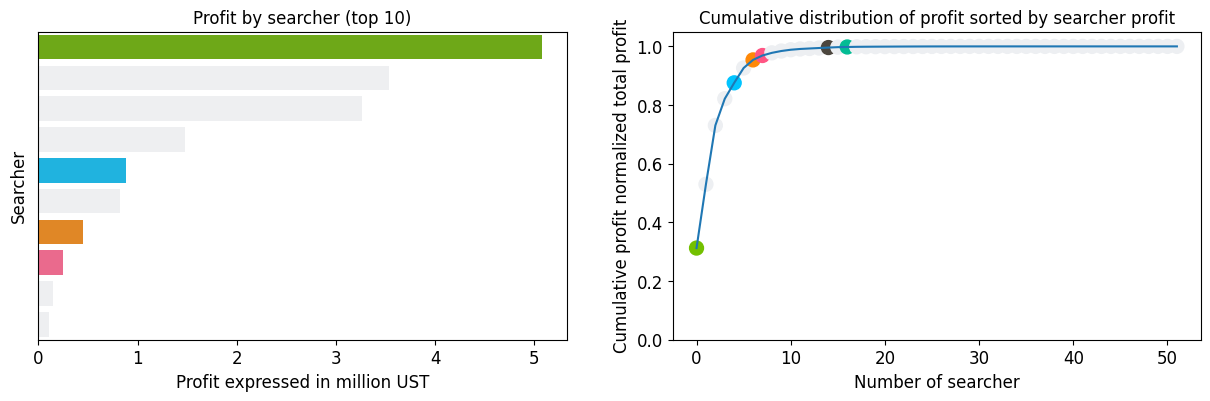

In [47]:
plt.subplot(1, 2, 1)

df_searcher = (
    df_arbs[df_arbs.token_in == "uusd"]
    .groupby("searcher", as_index=False)
    .sum(numeric_only=True)["searcher profit".split()]
    .sort_values("profit", ascending=False)
)

df_searcher["searcher_color"] = df_searcher.searcher.apply(
    lambda x: df_arbs[df_arbs.searcher == x].searcher_color.unique()[0]
)
df_searcher["searcher_number_of_contracts"] = df_searcher.searcher.apply(
    lambda x: len(df_arbs[df_arbs.searcher == x].contract.unique())
)
df_searcher["searcher_number_of_senders"] = df_searcher.searcher.apply(
    lambda x: len(df_arbs[df_arbs.searcher == x].sender.unique())
)


# lo expreso en UST, luego lo expreso en 1M UST
df_searcher["profit_in_millions"] = df_searcher.profit / 10**12

sns.barplot(
    data=df_searcher.iloc[:10],
    y="searcher",
    x="profit_in_millions",
    orient="h",
    palette=df_searcher.searcher_color,
    order=df_searcher.iloc[:10].searcher,
)
plt.xlabel("Profit expressed in million UST")
plt.ylabel("Searcher")
plt.title("Profit by searcher (top 10)")
# plt.xscale('log')
plt.yticks([])

plt.subplot(1, 2, 2)
plt.scatter(
    range(len(df_searcher.profit)),
    df_searcher.profit.cumsum().values / df_searcher.profit.sum(numeric_only=True),
    c=df_searcher.searcher_color.tolist(),
    s=100,
)
plt.xlabel("Number of searcher")
plt.title("Cumulative distribution of profit sorted by searcher profit")
plt.ylabel("Cumulative profit normalized total profit")
plt.ylim(0, 1.05)

fig = plt.gcf()
plt.plot(range(len(df_searcher.profit)), df_searcher.profit.cumsum().values / df_searcher.profit.sum(numeric_only=True))
_ = fig.set_size_inches(15, 4)


## Correlation between number of contracts and senders with profit

In [49]:
print(pearsonr(df_searcher.searcher_number_of_contracts, df_searcher.profit_in_millions))
print(pearsonr(df_searcher.searcher_number_of_senders, df_searcher.profit_in_millions))
df_searcher.corr(numeric_only=True)

PearsonRResult(statistic=0.7413441991192776, pvalue=3.264609837649605e-10)
PearsonRResult(statistic=0.5653362358747961, pvalue=1.2609666381371703e-05)


,searcher,profit,searcher_number_of_contracts,searcher_number_of_senders,profit_in_millions
searcher,1.000000,-0.439506,-0.482080,-0.398606,-0.439506
profit,-0.439506,1.000000,0.741344,0.565336,1.000000
searcher_number_of_contracts,-0.482080,0.741344,1.000000,0.841720,0.741344
searcher_number_of_senders,-0.398606,0.565336,0.841720,1.000000,0.565336
profit_in_millions,-0.439506,1.000000,0.741344,0.565336,1.000000


# Amount in

Statistics description arbs with UST


count    1.658180e+05
mean     5.087075e+09
std      2.129378e+10
min      1.644000e+03
25%      2.593934e+08
50%      9.985993e+08
75%      3.166643e+09
max      1.120000e+12
Name: amount_in, dtype: float64

Statistics description arbs with LUNA


count    1.975000e+04
mean     4.047445e+08
std      8.340747e+08
min      9.506000e+03
25%      2.000000e+07
50%      8.897780e+07
75%      4.705990e+08
max      1.104929e+10
Name: amount_in, dtype: float64

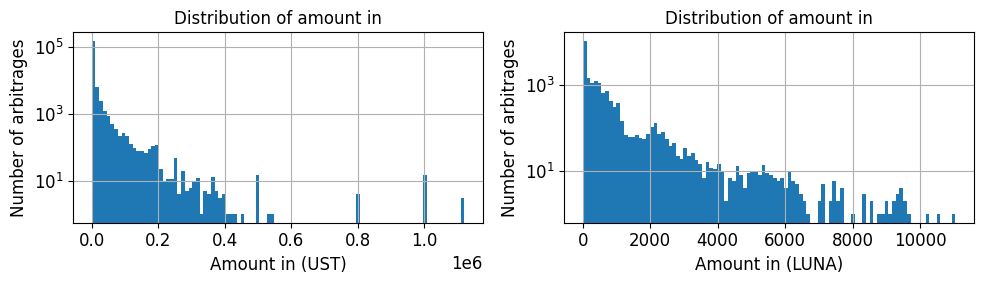

In [74]:
plt.subplot(1, 2, 1)
(df_arbs[((df_arbs.token_in == "uusd"))].amount_in / 10**6).hist(bins=100)
plt.yscale("log")
plt.xlabel("Amount in (UST)")
plt.ylabel("Number of arbitrages")
plt.title("Distribution of amount in")


plt.subplot(1, 2, 2)
(df_arbs[((df_arbs.token_in == "uluna"))].amount_in / 10**6).hist(bins=100)
plt.yscale("log")
plt.xlabel("Amount in (LUNA)")
plt.ylabel("Number of arbitrages")
plt.title("Distribution of amount in")

fig = plt.gcf()
fig.set_size_inches(10, 3)
fig.tight_layout()

print('Statistics description arbs with UST')
display(df_arbs[((df_arbs.token_in=='uusd'))].amount_in.describe())

print('Statistics description arbs with LUNA')
display(df_arbs[((df_arbs.token_in=='uluna'))].amount_in.describe())

# Cycles path len

Rate of cycles with 2 or 3 length 0.8091629367217497
Rate of cycles greather than 5 0.004502450096518951


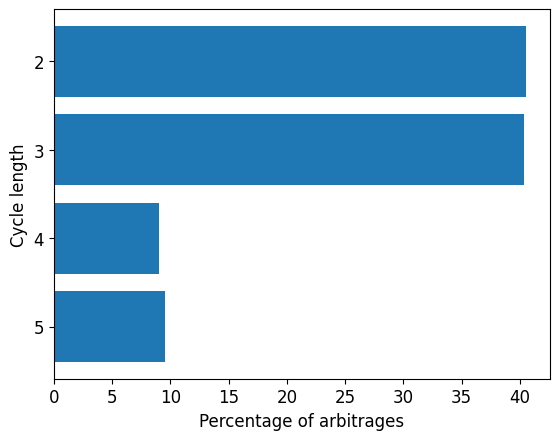

In [75]:
cn_path_len = Counter(pd.Series(path_len))
dom = np.arange(2, 6)
plt.barh(-dom, [100 * cn_path_len[l] / len(path_len) for l in dom])
plt.yticks(-dom, map(str, dom))
plt.xlabel("Percentage of arbitrages")
_ = plt.ylabel("Cycle length")
print('Rate of cycles with 2 or 3 length',(cn_path_len[2]+cn_path_len[3])/len(path_len))
print('Rate of cycles greather than 5',1- sum([cn_path_len[i] for i in range(2,6)])/len(path_len))


# Failed arbs

## Summary

In [52]:
print('Sums')
display(df_blocks.sum(numeric_only=True))

print('Correlations')
display(df_blocks.corr(numeric_only=True))

print('Rate of failed/successful', df_blocks.sum(numeric_only=True).n_arbs_failed/df_blocks.sum(numeric_only=True).n_arbs_successful)
print('Rate of failed/total exec txs', df_blocks.sum(numeric_only=True).n_arbs_failed/df_blocks.sum(numeric_only=True).n_txs_exec)
print('Rate of n_arbs_successful/total exec txs', df_blocks.sum(numeric_only=True).n_arbs_successful/df_blocks.sum(numeric_only=True).n_txs_exec)
print('Pearson correlation between succesful and failed arbs', pearsonr(df_blocks.n_arbs_successful, df_blocks.n_arbs_failed))

Sums


n_arbs_successful          188564
n_arbs_failed              670258
n_txs                     7456097
n_txs_exec                3534197
height               823444735486
n_arbs                     858822
dtype: int64

Correlations


,n_arbs_successful,n_arbs_failed,n_txs,n_txs_exec,height,n_arbs
n_arbs_successful,1.000000,0.455176,0.173555,0.413164,0.027708,0.531727
n_arbs_failed,0.455176,1.000000,0.280364,0.716884,0.130281,0.996124
n_txs,0.173555,0.280364,1.000000,0.410415,0.057641,0.283816
n_txs_exec,0.413164,0.716884,0.410415,1.000000,0.145678,0.722686
height,0.027708,0.130281,0.057641,0.145678,1.000000,0.126655
n_arbs,0.531727,0.996124,0.283816,0.722686,0.126655,1.000000


Rate of failed/successful 3.5545385121232047
Rate of failed/total exec txs 0.18964930364662752
Rate of n_arbs_successful/total exec txs 0.053354128250349374
Pearson correlation between succesful and failed arbs PearsonRResult(statistic=0.4551760180538583, pvalue=0.0)


## Create dataframes of failed and successful arbs

In [53]:
def create_dataframes_of_succesful_and_failed_arbs(df_arbs):
    validated_arbs_successful = set(df_arbs.txhash)
    failed_arbs = {}
    successfull_arbs = {}

    for arb in tqdm(arbs):
        for a in arb['other_arbs']:
            if a['success'] == False:
                a['height'] = arb['block']
                a['txhash'] = a['txhas']
                failed_arbs[a['txhash']] = a
        r = {'contract':arb['arb']['contract'], 'sender':arb['arb']['sender'], 'txhash':arb['arb']['txhash'], 'gas_wanted':arb['arb']['gas_wanted'], 'height': arb['block']}
        successfull_arbs[arb['arb']['txhash']]= r
        
    df_failed_arbs = pd.DataFrame(failed_arbs.values())
    # remove original typo in raw_data
    del df_failed_arbs['txhas']
    df_successful_arbs = pd.DataFrame(successfull_arbs.values())

    return df_failed_arbs, df_successful_arbs

df_failed_arbs, df_successful_arbs = create_dataframes_of_succesful_and_failed_arbs(df_arbs)

print('Failed')
display(df_failed_arbs)

print('Successful')
display(df_successful_arbs)


100%|██████████| 188564/188564 [00:01<00:00, 150409.37it/s]


Failed


,fee,fee_token,sender,contract,success,gas_wanted,height,txhash
0,1500000,usek,terra1djkwwpgevx42h8j7zwtgtvy2zcd2z345n5kuhn,terra1c0afrdc5253tkp5wt7rxhuj42xwyf2lcre0s7c,False,1200000,7295407,601c31ef32a470c7f8258cb2d32797853c43a26df33462...
1,300001,uusd,terra1q50l8kpuvtt5w5ufsrre6z4548nyw7wsv89u7a,terra12hgne54rm0gmhmmehh2p0qhz94dch2y426dqlr,False,2000000,7295303,1eb13394bfc6758b512f2bf6b1664cf3a2727d2fa90f54...
2,2500000,usek,terra12glyg2am7ttfwrypv4phz340x84f728cm7pa53,terra1yrc0zpwhuqezfnhdgvvh7vs5svqtgyl7pu3n6c,False,2000000,7295418,f57b31fadc1341051f5b47085480304160197b89c8be0f...
3,2500000,usek,terra12glyg2am7ttfwrypv4phz340x84f728cm7pa53,terra1yrc0zpwhuqezfnhdgvvh7vs5svqtgyl7pu3n6c,False,2000000,7295438,4b4e16c069a1b777d276730f1be90a0caa51d29d497f74...
4,2000000,usek,terra16du2sw6my7gxp6lj05puqejhdgu5cktey65t9l,terra1ulcqs9k8dtlayptycfc4pcjzrh64gldv67fsak,False,1600000,7295467,44d759794f6ef5d60cc980851c06657fb9493cb91d5774...
...,...,...,...,...,...,...,...,...
670253,180000,uusd,terra1ah6rmkd8lgke8lfm3v5epauzkhmmnst5jkufjt,terra1lwjuryyjd2qfpt2jk39lenttl9z76y5hgqumq7,False,1200000,7295198,0f032080c355626aa354b51ec031ed371cd5f067e3f07e...
670254,232501,uusd,terra16vlernjh34ana3vcs6zae5hdr38rtpxqkc0ay6,terra12hgne54rm0gmhmmehh2p0qhz94dch2y426dqlr,False,1550000,7295198,6312c8b4991d828f04aa2872c20a09caa137e5536e812f...
670255,180000,uusd,terra1u3ta25sfgzhqhg9k9upqhmm232ltcukew2289t,terra1lwjuryyjd2qfpt2jk39lenttl9z76y5hgqumq7,False,1200000,7295198,6d183d498ff88874733042e5228d4f2d06b3d301dc540e...
670256,126000,uusd,terra175yp3rnjk2av64zlkt777kkqa7f829g2hfpn4l,terra123neekasfmvcs4wa70cgw3j3uvwzqacdz2we03,False,770000,7295198,ccf9c721b66dbf6b369532254553826304c8b4ef521b2c...


Successful


,contract,sender,txhash,gas_wanted,height
0,terra1a8pae49synr07t0q058pu39gclrqz0eq04dngt,terra1qdj0ku3sww7pcy36kf7q6rupga9rcur8v5plp5,f8e35eedf50239329c3afeb541cbcab1a550f08188e9b8...,2000000,7295407
1,terra1eqmxmc4j39cyv5zk52dyjmhmhztudj24n77n2q,terra1vadgym4eqxsxetl9xgka8cfkd5mjcvwc2f8pyt,0935909ed8f6d6af7f5920fd69c80f6f939198ff55b632...,2333330,7295368
2,terra1egqmcaupc87sdg6sqmzypuv06ykxkek3j7s4w5,terra1nyud8zzctrks6ltnhhn4q820umnvqg39hc6ydz,c04fec46e1e39a1607fe36e88000a40ef0ca2bd937b625...,1500000,7295303
3,terra1g7jjjkt5uvkjeyhp8ecdz4e4hvtn83sud3tmh2,terra1p0242gewpx8pcr8hnp57ylmzef6mkp664ysxw4,81e7b25a49e859df22ffde299d1c463cbf4e00d74b6e82...,8040730,7295408
4,terra1eqmxmc4j39cyv5zk52dyjmhmhztudj24n77n2q,terra1tekdk5q9w22cf8xzsr43xdgre6zfgz94d5zguh,d40e6d1969c5f0a50287eacd24494774770adecbd06e9e...,2333330,7295418
...,...,...,...,...,...
188559,terra1egqmcaupc87sdg6sqmzypuv06ykxkek3j7s4w5,terra1nyud8zzctrks6ltnhhn4q820umnvqg39hc6ydz,d874bf02670b3a87e9138ec5a66e0a342ac69e78245085...,1000000,7295109
188560,terra1egqmcaupc87sdg6sqmzypuv06ykxkek3j7s4w5,terra1nyud8zzctrks6ltnhhn4q820umnvqg39hc6ydz,6b01e2c0b73f840c08c7e2147a4468dff373579c24bd02...,1000000,7295213
188561,terra1lwjuryyjd2qfpt2jk39lenttl9z76y5hgqumq7,terra1kdhj4v87qgejcmllxa3w67w7n507afmmgwp66v,1b1bce174b56f075d00ff6ed8fdcf6f21ac14cb0b636c3...,1200000,7295198
188562,terra139y02s9urkkyesukndrqdjmqj7gkk5dltd05v8,terra1j96rykcvql98wsrmw62hcgqer2kz78wup039gw,cd29251588a805579d1615df1724eb4acca49bb97dfd28...,1200000,7295206


## Gas wanted analysis

In [54]:
print('Successful arbs total gas wanted', df_successful_arbs.gas_wanted.sum())
print('Failed arbs total gas wanted', df_failed_arbs.gas_wanted.sum())
print('Rate of gas wanted for failed arbs over successful', df_failed_arbs.gas_wanted.sum()/df_successful_arbs.gas_wanted.sum())

Successful arbs total gas wanted 445619892115
Failed arbs total gas wanted 1357865045661
Rate of gas wanted for failed arbs over successful 3.0471374139433145


## Add more info to df_searcher about failed and successful

In [55]:
def add_seaecher_to_df_failed_arbs(df_failed_arbs, df_arbs):
    d = dict(df_arbs['contract searcher'.split()].drop_duplicates().values)
    d.update(df_arbs['sender searcher'.split()].drop_duplicates().values)

    def define_searcher_from_fialed_arb(r):
        if r.contract in d:
            return d[r.contract]
        if r.sender in d:
            return d[r.sender]
        return np.nan


    df_failed_arbs['searcher'] = df_failed_arbs.apply(define_searcher_from_fialed_arb, axis=1)
    
add_seaecher_to_df_failed_arbs(df_failed_arbs, df_arbs)
df_successful_arbs = df_successful_arbs.merge(df_arbs['txhash searcher'.split()])


dic_searcher__count_successful_arbs = dict(df_successful_arbs.groupby('searcher', as_index=False).count()['searcher contract'.split()].values)
dic_searcher__gas_wanted_sucessful_arbs = dict(df_successful_arbs.groupby('searcher', as_index=False).gas_wanted.sum().values)

dic_searcher__count_failed_arbs = defaultdict(lambda :0)
dic_searcher__count_failed_arbs.update(dict(df_failed_arbs.groupby('searcher', as_index=False).count()['searcher contract'.split()].values))
dic_searcher__gas_wanted_failed_arbs = dict(df_failed_arbs.groupby('searcher', as_index=False).gas_wanted.sum().values)

# add new field to df_searcher
df_searcher['gas_wanted_successful_arbs'] = df_searcher.searcher.apply(lambda x: dic_searcher__gas_wanted_sucessful_arbs[x])
df_searcher['total_successful_arbs'] = df_searcher.searcher.apply(lambda x: dic_searcher__count_successful_arbs[x])
df_searcher['gas_wanted_failed_arbs'] = df_searcher.searcher.apply(lambda x: dic_searcher__gas_wanted_sucessful_arbs[x])
df_searcher['total_failed_arbs'] = df_searcher.searcher.apply(lambda x: dic_searcher__count_failed_arbs[x])
df_searcher['total_arbs'] = df_searcher.total_successful_arbs + df_searcher.total_failed_arbs
df_searcher['successful_rate'] = df_searcher.total_successful_arbs/(df_searcher.total_successful_arbs+df_searcher.total_failed_arbs)

df_searcher.head()

,searcher,profit,searcher_color,searcher_number_of_contracts,searcher_number_of_senders,profit_in_millions,gas_wanted_successful_arbs,total_successful_arbs,gas_wanted_failed_arbs,total_failed_arbs,total_arbs,successful_rate
0,0,5075511455757,#73c000,23,62,5.075511,77815801686,32982,77815801686,128252.0,161234.0,0.204560
11,13,3532900775058,#edeff2,7,7,3.532901,70699700000,32327,70699700000,95064.0,127391.0,0.253762
3,4,3260752836306,#edeff2,8,12,3.260753,50833989402,26074,50833989402,76429.0,102503.0,0.254373
2,3,1476217285897,#edeff2,5,8,1.476217,9205252183,4471,9205252183,61376.0,65847.0,0.067900
8,10,880230711114,#00c4ff,17,55,0.880231,55288841832,21573,55288841832,28329.0,49902.0,0.432307


# Relation between successful rate and profit

50 0.6153846153846154


Text(0.5, 1.0, 'Relation between success rate and profit\n(considering searchers with more than 50 successful\n arbitrages) Spearman rho: -0.5821 p-value: 0.0005')

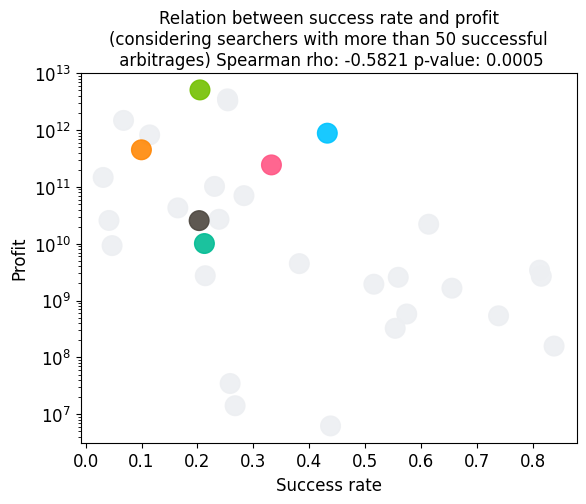

In [94]:
th = 50
mask = df_searcher.total_successful_arbs>= th
print(th, (mask).mean())

df_searcher_filtered = df_searcher[mask].copy()

plt.scatter(df_searcher_filtered.successful_rate, df_searcher_filtered.profit, c=df_searcher_filtered.searcher_color, s=200, alpha=0.9)
plt.yscale('log')
plt.xlabel('Success rate')
plt.ylabel('Profit')

spearman_rho, spearman_p = spearmanr(df_searcher_filtered.successful_rate, df_searcher_filtered.profit)

plt.title(f'Relation between success rate and profit\n(considering searchers with more than {th} successful\n arbitrages) Spearman rho: {spearman_rho:.4f} p-value: {spearman_p:.4f}')

In [59]:
for th in [10,50,100,250,500,750]:
    mask = df_searcher.total_successful_arbs>=th
    df_searcher_filtered = df_searcher[mask].copy()
    rho, pval = spearmanr(df_searcher_filtered.successful_rate, np.log(df_searcher_filtered.profit))
    print('thrshold', th, 'percentil',int(percentileofscore(df_searcher.total_successful_arbs, th)),'number of searcher included', (df_searcher.total_successful_arbs>th).sum(),'rho', f'{rho:.4f}', 'pval', f'{pval:.4f}')


thrshold 10 percentil 23 number of searcher included 40 rho -0.4869 pval 0.0014
thrshold 50 percentil 38 number of searcher included 32 rho -0.5821 pval 0.0005
thrshold 100 percentil 44 number of searcher included 29 rho -0.6084 pval 0.0005
thrshold 250 percentil 46 number of searcher included 28 rho -0.6349 pval 0.0003
thrshold 500 percentil 53 number of searcher included 24 rho -0.5983 pval 0.0020
thrshold 750 percentil 55 number of searcher included 23 rho -0.5652 pval 0.0049


# Analysis of menssages of fialed arbs to check if bots are using multi instance

In [62]:
# read tx exemsg
df_txhash_execmsg = pd.read_csv('./data/txhash_execmsg.csv.zip')
dic = dict(df_txhash_execmsg.values)
df_successful_arbs['execmsg'] = df_successful_arbs.txhash.apply(lambda x: dic[x])
df_failed_arbs['execmsg'] = df_failed_arbs.txhash.apply(lambda x: dic[x])

In [63]:
# compute the rate of tx repetition by (heigh, searcher)
# 1 es is the lower value increase when the tx is repeated
df_same_tx_same_block = df_failed_arbs.groupby('height searcher'.split(), as_index=False).apply(lambda x: len(x.execmsg)/x.execmsg.nunique())
df_same_tx_same_block.columns = 'height searcher rate_repeated_tx'.split()

## define rate_repeated_tx

In [64]:
# add to df_searcher the rate of repeated txs, this is how many times a searcher has repeated a tx in the same block in average
df_searcher['rate_repeated_tx'] = df_searcher.merge(df_same_tx_same_block.groupby('searcher', as_index=False).mean(numeric_only=True)['searcher rate_repeated_tx'.split()])['rate_repeated_tx']

In [66]:
df_searcher[df_searcher.total_successful_arbs>50].rate_repeated_tx.describe()

count    32.000000
mean      1.317468
std       0.558225
min       1.000000
25%       1.000000
50%       1.035362
75%       1.460846
max       3.539638
Name: rate_repeated_tx, dtype: float64

## colreation between mean rate_repeated_tx and profit

Text(0.5, 1.0, 'Relation between rate_repeated_tx and profit\n(considering searchers with more than 50 percentile \nof successful arbitrages) Spearman rho: 0.6022 p: 0.0011')

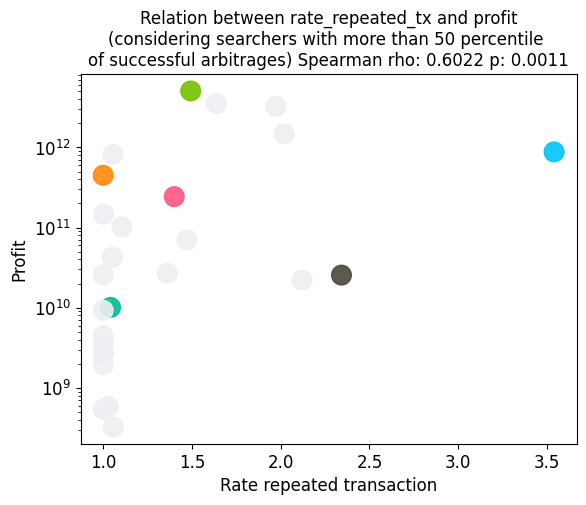

In [90]:
th = 50
mask = df_searcher.total_arbs> np.percentile(df_searcher.total_arbs, th)

df_searcher_filtered = df_searcher[mask].copy()

plt.scatter(df_searcher_filtered.rate_repeated_tx, df_searcher_filtered.profit, c=df_searcher_filtered.searcher_color, s=200, alpha=0.9)
plt.yscale('log')
plt.xlabel('Rate repeated transaction')
plt.ylabel('Profit')

spearman_rho, spearman_p = spearmanr(df_searcher_filtered.rate_repeated_tx, df_searcher_filtered.profit)

plt.title('Relation between rate_repeated_tx and profit\n(considering searchers with more than 50 percentile \nof successful arbitrages) Spearman rho: {:.4f} p: {:.4f}'.format(spearman_rho, spearman_p))